In [4]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoProcessor
from datasets import load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoProcessor
from transformers import AutoProcessor, LlavaForConditionalGeneration
from IPython.display import display

In [3]:
def build_filtered_test_dataset(dataset_name='derek-thomas/ScienceQA',
                                 split='test',
                                 keep_grades='1-6'):
    """
    构建按年级过滤的测试数据集（不限制样本数量）。

    参数:
        dataset_name (str): 数据集名称，例如 'derek-thomas/ScienceQA'。
        split (str): 数据分割，例如 'train', 'test', 'validation'。
        keep_grades (str or None): 筛选的年级段："1-6"、"7-12" 或 None 表示不过滤。

    返回:
        List[Dict]: 筛选后的样本列表。
    """

    def is_grade_allowed(grade_str):
        if keep_grades is None:
            return True
        try:
            grade_num = int(grade_str.replace("grade", ""))
            if keep_grades == "1-6":
                return 1 <= grade_num <= 6
            elif keep_grades == "7-12":
                return 7 <= grade_num <= 12
        except:
            return False
        return False

    data = load_dataset(dataset_name, split=split)
    test_dataset = []

    for i, sample in enumerate(data):
        try:
            if sample.get('question') is None:
                continue

            if not is_grade_allowed(sample.get("grade", "")):
                continue

            solution = sample.get("solution", "")
            lecture = sample.get("lecture", "")
            solution_lecture = f"{solution}\n\n{lecture}".strip()

            test_dataset.append({
                "image": sample.get("image", None), 
                "question": sample["question"],
                "choices": sample["choices"],
                "hint": sample["hint"],
                "answer": sample["answer"],
                "solution_lecture": solution_lecture,
                'grade':sample["grade"],
            })

        except Exception as e:
            print(f"跳过第 {i} 个样本，错误：{e}")
            continue

    return test_dataset

In [5]:
test_dataset = build_filtered_test_dataset(dataset_name='derek-thomas/ScienceQA',
                                    split='test',
                                    keep_grades='1-6')

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=426x283 at 0x7F7C33B6E050>, 'question': 'Is the following statement about our solar system true or false?\nThe largest planet is made mainly of ice.', 'choices': ['true', 'false'], 'hint': 'Use the data to answer the question below.', 'answer': 1, 'solution_lecture': "The table tells you that Jupiter is the largest planet and that Jupiter is made mainly of gas. So, the largest planet is made mainly of gas.\n\nA planet's volume tells you the size of the planet.\nThe primary composition of a planet is what the planet is made mainly of. In our solar system, planets are made mainly of rock, gas, or ice.", 'grade': 'grade6'}


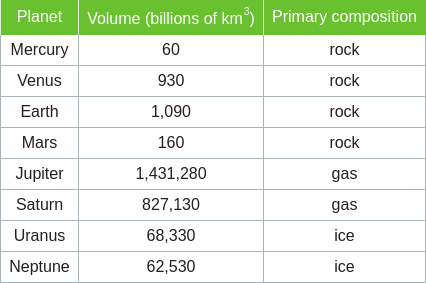

In [28]:
n = 7
print (test_dataset[n])
display(test_dataset[n]["image"])

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

Using device: cuda


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 12.77it/s]


In [45]:
def build_message(sample):
    content = []
    if sample['image'] is not None:
        content.append({"type": "image", "image": sample['image']})
    
    question_text = f"Question: {sample['question']}\nChoices:\n"
    for idx, choice in enumerate(sample['choices']):
        question_text += f"{chr(65 + idx)}. {choice}\n"
    
    if sample.get("hint"):
        question_text += f"\nHint: {sample['hint']}\n"
    
    question_text += ("\nPlease select the correct answer. "
        "Then, explain your reasoning in detail. "
        "Make sure your explanation is at least three sentences long, "
        "refers to specific data from the image, and shows your step-by-step logic.")
    content.append({"type": "text", "text": question_text})
    
    return [{"role": "user", "content": content}]


[{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=426x283 at 0x7F7C33B6E050>}, {'type': 'text', 'text': 'Question: Is the following statement about our solar system true or false?\nThe largest planet is made mainly of ice.\nChoices:\nA. true\nB. false\n\nHint: Use the data to answer the question below.\n\nPlease select the correct answer. Then, explain your reasoning in detail. Make sure your explanation is at least three sentences long, refers to specific data from the image, and shows your step-by-step logic.'}]}]


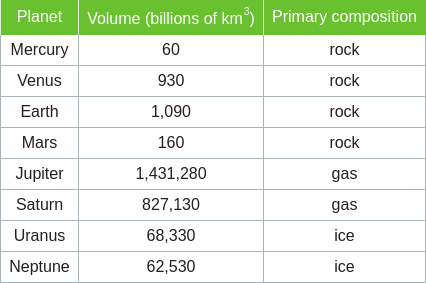

In [46]:
n = 7
print (build_message(test_dataset[n]))
display(test_dataset[n]["image"])

In [52]:
# 解析模型输出中的选项字母
def parse_output(output):
    output = output.strip()
    answer_match = re.search(r"\b([A-D])[\.\:]", output)
    if answer_match:
        answer = ord(answer_match.group(1)) - 65
    else:
        answer = -1
    explanation = ""
    if answer != -1:
        idx = output.find(answer_match.group(0))
        if idx != -1:
            explanation = output[idx + len(answer_match.group(0)):].strip()
    return answer, explanation

# 初始化工具
rouge = Rouge()
smoothie = SmoothingFunction().method1
vectorizer = CountVectorizer(stop_words="english").fit([s["solution_lecture"] for s in test_dataset])
keywords = set(vectorizer.get_feature_names_out())

# 开始评估
all_records = []

for sample in tqdm(test_dataset):
    messages = build_message(sample)
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs = [sample["image"]] if sample["image"] else None

    inputs = processor(text=[text], images=image_inputs, return_tensors="pt", padding=True).to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=512)
    output = processor.batch_decode(generated_ids[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True)[0]

    pred_answer, pred_explanation = parse_output(output)
    true_answer = sample["answer"]

    # BLEU-1 和 BLEU-4
    reference = sample["solution_lecture"].split()
    hypothesis = pred_explanation.split()
    bleu1 = sentence_bleu([reference], hypothesis, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu([reference], hypothesis, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    # ROUGE-L
    try:
        rouge_score = rouge.get_scores(pred_explanation, sample["solution_lecture"])[0]["rouge-l"]["f"]
    except:
        rouge_score = 0.0

    # 关键词重叠
    gt_tokens = set(sample["solution_lecture"].lower().split())
    pred_tokens = set(pred_explanation.lower().split())
    overlap = len(gt_tokens & pred_tokens & keywords)
    keyword_score = overlap / max(len(gt_tokens & keywords), 1)

    all_records.append({
        "Question": sample["question"],
        "Choices": "\n".join(sample["choices"]),
        "True Answer": true_answer,
        "Predicted Answer": pred_answer,
        "Predicted Answer Text": sample["choices"][pred_answer] if 0 <= pred_answer < len(sample["choices"]) else "N/A",
        "Model Output": output,
        "Model Explanation": pred_explanation,
        "Reference Solution": sample["solution_lecture"],
        "BLEU-1": bleu1,
        "BLEU-4": bleu4,
        "ROUGE-L": rouge_score,
        "Keyword Overlap": keyword_score
    })

# 结果表格
results_df = pd.DataFrame(all_records)

# 汇总评估
acc = accuracy_score(results_df["True Answer"], results_df["Predicted Answer"])
f1 = f1_score(results_df["True Answer"], results_df["Predicted Answer"], average='macro')
avg_bleu1 = results_df["BLEU-1"].mean()
avg_bleu4 = results_df["BLEU-4"].mean()
avg_rouge = results_df["ROUGE-L"].mean()
avg_keyword_overlap = results_df["Keyword Overlap"].mean()

# 打印汇总结果
print("\nSummary Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Avg BLEU-1: {avg_bleu1:.4f}")
print(f"Avg BLEU-4: {avg_bleu4:.4f}")
print(f"Avg ROUGE-L: {avg_rouge:.4f}")
print(f"Avg Keyword Overlap: {avg_keyword_overlap:.4f}")

# 保存为 CSV
results_df.to_csv("llava_1_6_evaluation_results_scienceQA.csv", index=False,encoding="utf-8-sig")
print("\n✅ 结果已保存为 llava_evaluation_results_scienceQA.csv")


100%|██████████| 2724/2724 [1:41:24<00:00,  2.23s/it]  


Summary Metrics:
Accuracy: 0.5466
F1 Score: 0.4543
Avg BLEU-1: 0.0679
Avg BLEU-4: 0.0153
Avg ROUGE-L: 0.1460
Avg Keyword Overlap: 0.1312

✅ 结果已保存为 llava_evaluation_results_scienceQA.csv
